# Hyperparameter Search Sampling Strategy using Hyperopt

__Abstract:__ This project considers how KFold and a fixed train-validation affects the performance of the scikit-learn
estimator *AdaBoostRegressor* on a credit card default dataset. The dataset consists of 30,000 labelled points with 23
features. The Hyperopt optimization framework is used with 30 search iterations for hyperparameters per optimization.
Ten simulations found an average of . Model tuning using KFold is higher than a fixed train-validation set at a p-value
of 0.0134. At a confidence level of 95%, KFold tuning is has  increases the performance of test accuracy 0.0224%, given
the simulation settings. Further performance measures, such as roc-auc score and real good of probability estimation
(found using the smooth sorting method), were not found to have difference at 95% confidence level.

* __[Link to original paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719)__

* __[Link to UCI dataset page](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__
<br>

### Project Method
1. data preparation, including imports and scaling
2. hyperparameter optimization space
3. objective function build
4. model build using Hyperopt
5. model evaluation, includes 'smooth sorting method'


## Import : Data and Libraries
### Library Imports

In [2]:
# Imports
%matplotlib widget

from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import pickle

from matplotlib.widgets import Slider, Button, RadioButtons

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Optimizer
from hyperopt import Trials, fmin, tpe

from evaluation_helper import performance_metrics


# Model hyperparameter space to be optimized
from hyperparameters_spaces import ada_loss_functions, ada_space, log_space, svm_space, svm_kernels, \
    svm_kernel_degrees, xgb_space, INT_KEYS

# Model objective function builder
from hyperopt_objective import build_objective_func

sns.set_style("dark")
sns.set_context("paper")


### Import and pre-processing of dataset 
(preprocessing : transforming data into ML model readable format)

#### Data Importing

In [2]:
# load data internally
_df_train = pd.read_csv("DataFiles/CreditCard_train.csv", index_col=0, header=1)
_df_test = pd.read_csv("DataFiles/CreditCard_test.csv", index_col=0, header=1)

# create external df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()


#### Train data head and description

In [3]:
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df_train.describe()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,-0.252917,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,1.136993,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


### Pandas DataFrame processing

In [5]:
# renaming columns for consistency and simplicity
df_train = df_train.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
df_test = df_test.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

label = df_train.columns[-1] # = `DEFAULT`
features = list(df_train.columns)[:-1]

Formatting X, y as `np.ndarray`

In [6]:

y_train = df_train[label].to_numpy()
X_train = df_train[features]

y_test = df_test[label].to_numpy()
X_test = df_test[features]


__Comment__ : All the data types are integers and thus workable for ML models. There are no null values (arbitrarily checked and all features have the same count). Values in the `SEX`, `EDUCATION` are have a specified range, however, some values are not contained.


## Data Pipeline
* includes scaling, sampling and (future work : feature transformation)


Scaling the dataset for computational efficiency for some ML algorithmns. (AdaBoost is an exception but in case other algorithmns are used)


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Benchmarking some standard ML models


### Tuning

For tuning we will be first split up the training data into a validation


In [8]:
def build_hyperopt_fitted_model(algorithmn, X_train : np.ndarray, y_train : np.ndarray, hyperparameters_space : dict,
                                hyperparameters_choices : dict,  tuning_method : 'str' = 'train_validation_split',
                                tuning_value : float = 0.25, tuning_measure = 'accuracy tuning', max_evals : int = 1,
                                random_state : int = 0, **fitting_setting):
    """
    Fits a ML model on the training data with hyperparameters tuned by Hyperopt using a selected cross validation
    method.

    :param algorithmn: ML algorithm for building model
    :param hyperparameters_space: possible hyperparameters values
    :param hyperparameters_choices: dictionary with 'key' as the choice and 'values' as options
    :param X_train: X training data
    :param y_train: X training data labels
    :param tuning_method: method for tuning hyerparameters, either 'train_validation_split' or 'KFold'
    :param tuning_value: tuning method value
    :param tuning_measure: measure of score/performance on the validation set, either 'roc' or 'accuracy'
    :param max_evals: maximum number of evaluations for hyperparameters searching
    :param random_state: random_state
    :param fitting_setting: additional settings for fitting the model (e.g. sample weight)

    :return: fitted ML model
    """

    # create trail
    trials = Trials()

    tuning_objective = build_objective_func(algorithmn=algorithmn, X_train=X_train, y_train=y_train,
                                            tuning_method=tuning_method, tuning_value=tuning_value,
                                            tuning_measure=tuning_measure, random_state=random_state, **fitting_setting)

    print(f'Starting hyperparameter search with with {algorithmn}, {tuning_method}, {tuning_value}\n')
    model_best_hyperparams = fmin(fn = tuning_objective,
                            space = hyperparameters_space,
                            algo = tpe.suggest,
                            max_evals = max_evals,
                            trials = trials)

    ## in case hyperparameters must be integers (e.g. max_depth for decision trees)
    # fmin returns space in floats (for some reason changed the type int to float)
    if type(INT_KEYS) == list:
        for key in INT_KEYS:
            if key in model_best_hyperparams.keys():
                model_best_hyperparams[key] = int(model_best_hyperparams[key])

    # when model space is a choice, `model_best_hyperparams` gives the index of the selected choice
    # model options a dict with keys: as the option name and value as list of options
    if type(hyperparameters_choices) == dict:
        for choice, choice_option in hyperparameters_choices.items():
            if choice in model_best_hyperparams.keys(): # additional safety net
                model_best_hyperparams[choice] = choice_option[model_best_hyperparams[choice]]

    model = algorithmn(**model_best_hyperparams) # refering to the algorithmn with hyperparameters as model
    model.fit(X_train, y_train, **fitting_setting)

    return model


## Performance at given percentages
### robustness

To estimate the real probability, the Smooth Sorting Method can be used, which estimates the real probability by looking at neighboring points and taking the mean of these values. This quantification is meaningful for risk control.

__Smooth Sorting Method__ from the original paper (Yeh, I. C., & Lien, C. H. (2009)):

$$\text{P}_i = \frac{\sum_{j=-n}^{n}\text{Y}_{i-j}}{2n+1}$$

where $\text{P}_i$ is the estimated real probability of default, $\text{Y}_{i}$ is the binary variable of default (1) or non-default (0), $n$ is the number of data for smoothing.<br>
The Smooth Sorting Method is used on sorted data, from the lowest probability of default occuring to the highest probability of default occuring.


In [9]:
def SSM_real_probability(y_real : np.ndarray, y_predicted : np.ndarray, n : int, plot : bool = False):
    """
    Implements the 'Smooth Sorting Method'
    :param y_real:
    :param y_predicted:
    :param n:
    :param plot:
    :return: r2 score
    """
    sorted_index = np.argsort(y_predicted)
    y_real_sorted = y_real[sorted_index]
    y_predicted_sorted = y_predicted[sorted_index]

    intermediate_real_probability = np.array([])
    for counter in range(n, len(y_real)-n):
        intermediate_real_probability = np.append(intermediate_real_probability,
                                                  np.mean(y_real_sorted[counter-n:counter+n]))

    r2 = r2_score(y_real, y_predicted)

    if plot:
        y_predicted_selected = y_predicted_sorted[n:len(y_real)-n]
        plt.plot(y_predicted_selected,intermediate_real_probability)
        plt.grid(True)
        plt.xlim([0,1])
        plt.xlabel('Predicted probability')
        plt.ylabel('Real probability using SSM')
        plt.annotate(f'$R^2 = {r2}$', (0.05, 0.95))
        plt.grid(True, which='both')
        plt.show()

    print(f'r2 score : {r2}\n')
    return r2


In [10]:
algorithmns_list = [AdaBoostRegressor,
                    LogisticRegression,
                    xgb.XGBRegressor,
                    SVC
                    ]

# imported
hyperparameter_space_list = [ada_space,
                             log_space,
                             xgb_space,
                             svm_space
                             ]

hyperparameter_choices_list = [{'loss' : ada_loss_functions},
                               None,
                               None,
                               {'kernel' : svm_kernels, 'degree' : svm_kernel_degrees}
                               ]

Dictionary ordering
model_name (e.g. `ada`) -> tuning_method (`train_validation_split`, `train_validation_split_randomized`, `KFold`) -> tuning_value -> tuning_measure -> max_evals -> score (accuracy, roc)

In [3]:
# tuning_measures_list = ['accuracy tuning', 'roc auc tuning']
tuning_measures_list = ['accuracy tuning']
tuning_methods_dict = {'train_validation_split' : {}, 'train_validation_split_randomized' : {}, 'KFold' : {}}
# tuning_methods_dict = {'train_validation_split_randomized' : {}}


# model performance dictionary building
model_ref_names = ['ada', 'log', 'xgb', 'svm']
selected_models = [model_ref_names[0]]
MODELS_PERFORMANCES = {}
for model_name in selected_models:
    MODELS_PERFORMANCES[model_name] = copy.deepcopy(tuning_methods_dict)

print(MODELS_PERFORMANCES)

{'ada': {'train_validation_split': {}, 'train_validation_split_randomized': {}, 'KFold': {}}}


Set variable `long_run=True` for a long run.

In [4]:
# intialization
ratio_range = range(20,30+1,5)
KFold_range = range(4,5+1,1)
ratio_constant = [25]
KFold_constant = [4]

random_state = 0
n = 50

max_evals_range = range(25,35+1,10)
max_evals_constant = [30]


tuning_value_range_list = [ratio_range, ratio_range, KFold_range]
tuning_value_constant_list = [ratio_constant, ratio_constant, KFold_constant]


In [21]:
import time
start_time = time.time()

tuning_measure_performance = {}
performance_at_num_iterations = {}


for algorithmn, hyperparameters_space, hyperparameters_choices, model_name in zip(algorithmns_list,
                                                                                  hyperparameter_space_list,
                                                                                         hyperparameter_choices_list,
                                                                                      MODELS_PERFORMANCES):
    for tuning_method_iterator, tuning_value_range in zip(tuning_methods_dict, tuning_value_constant_list):
        for tuning_value_iterator in tuning_value_range:
            if tuning_method_iterator == 'train_validation_split' or tuning_method_iterator == 'train_validation_split_randomized':
                tuning_value_iterator = tuning_value_iterator/100 # setting as a decimal
            for max_evals_iterator in max_evals_constant:
                for tuning_measure_iterator in tuning_measures_list:
                    random_state = 0
                    flag = False
                    for simulation_counter in range(10):
                        model = build_hyperopt_fitted_model(algorithmn=algorithmn, X_train= X_train, y_train= y_train,
                                                            hyperparameters_space = hyperparameters_space,
                                                            hyperparameters_choices = hyperparameters_choices,
                                                            tuning_method = tuning_method_iterator,
                                                            tuning_measure = tuning_measure_iterator, tuning_value = tuning_value_iterator,
                                                            max_evals = max_evals_iterator,
                                                            random_state=random_state)

                        y_pred = model.predict(X_test)

                        if simulation_counter == 0:
                            performance = {'test accuracy': [performance_metrics(y_test, y_pred>0.5, confusion_matrix=False)],
                                       'test roc auc': [roc_auc_score(y_test,y_pred, average = 'macro')],
                                       'test r2': [SSM_real_probability(y_test,y_pred, n=n, plot=False)]}

                        if simulation_counter != 0:
                            performance = {'test accuracy': np.append(performance['test accuracy'], performance_metrics(y_test, y_pred>0.5, confusion_matrix=False)),
                                       'test roc auc': np.append(performance['test roc auc'],roc_auc_score(y_test,y_pred, average = 'macro')),
                                       'test r2': np.append(performance['test r2'],SSM_real_probability(y_test,y_pred, n=n, plot=False))}

                        random_state += 1

                    performance_at_num_iterations[max_evals_iterator] = [copy.deepcopy(performance)]
                    tuning_measure_performance[tuning_measure_iterator] = copy.deepcopy(performance_at_num_iterations)


                    # tuning_measure_performance[tuning_measure_iterator] = copy.deepcopy(performance)

                    assert type(tuning_measure_iterator) == str
                MODELS_PERFORMANCES[model_name][tuning_method_iterator][tuning_value_iterator] = copy.deepcopy(tuning_measure_performance)

# can stop the evaluation at 20 times and save parameters, this almost halves the simulation time. log model hyperparameters also don't change 

end_time = time.time()
print(end_time-start_time)

with open('results3.pkl', 'wb') as f:
    pickle.dump(MODELS_PERFORMANCES, f)

print(MODELS_PERFORMANCES)

NameError: name 'algorithmns_list' is not defined

In [13]:
MODELS_PERFORMANCES

{'ada': {'train_validation_split': {},
  'train_validation_split_randomized': {},
  'KFold': {}}}

In [5]:
with open('results/results2.pkl', 'rb') as f:
    MODELS_PERFORMANCES = pickle.load(f)

with open('results/results3.pkl', 'rb') as f:
    MODELS_PERFORMANCES_subsection = pickle.load(f)

MODELS_PERFORMANCES['ada']['train_validation_split_randomized'] = MODELS_PERFORMANCES_subsection['ada']['train_validation_split_randomized']

MODELS_PERFORMANCES

{'ada': {'train_validation_split': {0.25: {'accuracy tuning': {30: [{'test accuracy': array([0.83433333, 0.83416667, 0.83416667, 0.83333333, 0.83383333,
              0.834     , 0.833     , 0.83383333, 0.83216667, 0.83266667]),
       'test roc auc': array([0.76260561, 0.77328997, 0.78129999, 0.77698555, 0.79322667,
              0.75952681, 0.76978069, 0.77525535, 0.75874368, 0.76006333]),
       'test r2': array([ 0.20157778,  0.16544534,  0.0470552 ,  0.13767959, -0.25694302,
               0.21154652,  0.09885423,  0.10892094,  0.2030375 ,  0.20105234])}]}}},
  'train_validation_split_randomized': {0.25: {'accuracy tuning': {30: [{'test accuracy': array([0.8335    , 0.83466667, 0.833     , 0.833     , 0.83266667,
              0.83383333, 0.8325    , 0.83083333, 0.83466667, 0.83333333]),
       'test roc auc': array([0.7807004 , 0.76857358, 0.74780837, 0.78348362, 0.73798764,
              0.78225123, 0.73042079, 0.7662548 , 0.76067026, 0.77609288]),
       'test r2': array([ 0.13

Model performance of ada : `MODELS_PERFORMANCES['ada']['train_split_ratio']`

Plotting the performance on accuracy under different tuning strategies


accuracy arrays are stored in: `MODELS_PERFORMANCES['ada'][tuning_method_name][tuning_method_value][tuning_measure][max_evals][performance_score]`


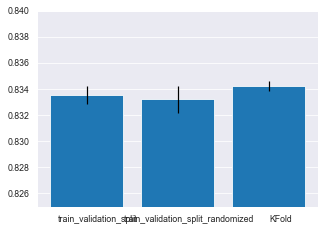

In [6]:
%matplotlib inline

max_evals = 30
performance_score = 'test accuracy'
tuning_measure = 'accuracy tuning'

results_split = MODELS_PERFORMANCES['ada']['train_validation_split'][0.25][tuning_measure][max_evals][0]
results_split_randomized = MODELS_PERFORMANCES['ada']['train_validation_split_randomized'][0.25][tuning_measure][max_evals][0]
results_kfold = MODELS_PERFORMANCES['ada']['KFold'][4][tuning_measure][max_evals][0]

results = [results_split, results_split_randomized, results_kfold]
acc_results_mean = [np.mean(result['test accuracy']) for result in results]
acc_results_std = [np.std(result['test accuracy']) for result in results]

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.20)

xticks_variables = list(tuning_methods_dict)

# The x position of bars
bar_width = 0.25
r1 = np.arange(len(xticks_variables))
r2 = [x + bar_width for x in r1]
positions = [r1, r2]

bars = ax.bar(r1, acc_results_mean, yerr=acc_results_std)

ax.set_xticklabels(xticks_variables)
ax.yaxis.grid(True)

plt.ylim([0.825, 0.84])
plt.xticks(r1+bar_width/2, xticks_variables)

plt.show()
display.display()


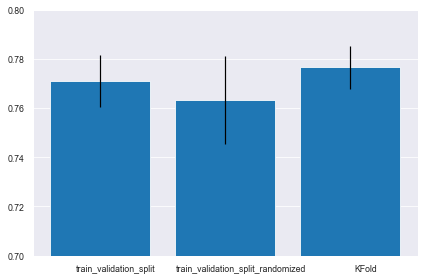

In [7]:
results = [results_split, results_split_randomized, results_kfold]
roc_auc_results_mean = [np.mean(result['test roc auc']) for result in results]
roc_auc_results_std = [np.std(result['test roc auc']) for result in results]

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.20)

xticks_variables = list(tuning_methods_dict)

# The x position of bars
bar_width = 0.25
r1 = np.arange(len(xticks_variables))
r2 = [x + bar_width for x in r1]
positions = [r1, r2]

bars = ax.bar(r1, roc_auc_results_mean, yerr=roc_auc_results_std)

ax.set_xticklabels(xticks_variables)
ax.yaxis.grid(True)

plt.ylim([0.7, 0.8])
plt.xticks(r1+bar_width/2, xticks_variables)
plt.tight_layout()

plt.show()
display.display()

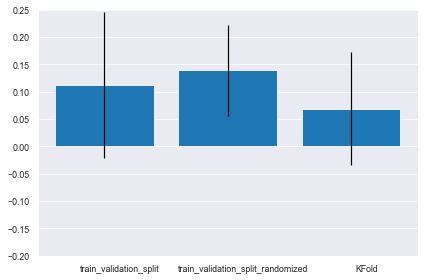

In [8]:
results = [results_split, results_split_randomized, results_kfold]
r2_results_mean = [np.mean(result['test r2']) for result in results]
r2_results_std = [np.std(result['test r2']) for result in results]

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.20)

xticks_variables = list(tuning_methods_dict)

# The x position of bars
bar_width = 0.25
r1 = np.arange(len(xticks_variables))
r2 = [x + bar_width for x in r1]
positions = [r1, r2]

bars = ax.bar(r1, r2_results_mean, yerr=r2_results_std)

ax.set_xticklabels(xticks_variables)
ax.yaxis.grid(True)

plt.ylim([-0.2, 0.25])
plt.xticks(r1+bar_width/2, xticks_variables)
plt.tight_layout()

plt.show()

In [18]:
MODELS_PERFORMANCES

{'ada': {'train_validation_split': {0.25: {'accuracy tuning': {30: [{'test accuracy': array([0.83433333, 0.83416667, 0.83416667, 0.83333333, 0.83383333,
              0.834     , 0.833     , 0.83383333, 0.83216667, 0.83266667]),
       'test roc auc': array([0.76260561, 0.77328997, 0.78129999, 0.77698555, 0.79322667,
              0.75952681, 0.76978069, 0.77525535, 0.75874368, 0.76006333]),
       'test r2': array([ 0.20157778,  0.16544534,  0.0470552 ,  0.13767959, -0.25694302,
               0.21154652,  0.09885423,  0.10892094,  0.2030375 ,  0.20105234])}]}}},
  'train_validation_split_randomized': {0.25: {'accuracy tuning': {30: [{'test accuracy': array([0.8335    , 0.83466667, 0.833     , 0.833     , 0.83266667,
              0.83383333, 0.8325    , 0.83083333, 0.83466667, 0.83333333]),
       'test roc auc': array([0.7807004 , 0.76857358, 0.74780837, 0.78348362, 0.73798764,
              0.78225123, 0.73042079, 0.7662548 , 0.76067026, 0.77609288]),
       'test r2': array([ 0.13

{25: {'test accuracy': 0.825, 'test roc auc': 0.7764703889913376, 'test r2': -0.32552712511850856}, 35: {'test accuracy': 0.833, 'test roc auc': 0.7833290284860753, 'test r2': 0.024273874025386943}}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

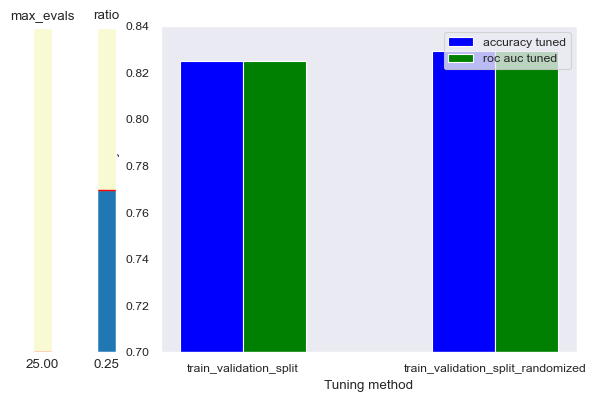

In [19]:
%matplotlib widget

with open('results/results.pkl', 'rb') as f:
    MODELS_PERFORMANCES = pickle.load(f)

tuning_measures_list = ['accuracy tuning', 'roc auc tuning']
tuning_methods_dict = {'train_validation_split' : {}, 'train_validation_split_randomized' : {}}
performance_name_list = ['test accuracy', 'test roc auc', 'test r2']

def select_plot_data(tuning_method_list : list, tuning_method_value : float, max_evals : int = 25, performance_score : str = 'test accuracy', tuning_measures_list : list = tuning_measures_list) -> tuple:
    score_list = []
    for tuning_method_iterator in tuning_method_list:
        for tuning_measure_name in tuning_measures_list:
            score_list.append(MODELS_PERFORMANCES[model_name][tuning_method_iterator][tuning_method_value][tuning_measure_name][max_evals][performance_score])

    accuracy_tuned_scores = score_list[::2]
    roc_auc_tuned_scores = score_list[1::2]

    return accuracy_tuned_scores, roc_auc_tuned_scores


ratio_0 = 0.25
max_evals_0 = 25

tuning_method_name = 'train_validation_split'
tuning_measure_name = tuning_measures_list[0] # = 'accuracy tuning'

performance_scores = ['test accuracy' , 'test roc auc', 'test r2']
selected_performance_score = performance_scores[0]

print(MODELS_PERFORMANCES['ada'][tuning_method_name][0.25][tuning_measure_name])

selected_data = select_plot_data(tuning_method_list=list(tuning_methods_dict), tuning_method_value=ratio_0, max_evals=max_evals_0, performance_score=selected_performance_score)
accuracy_tuned_score_list, roc_auc_tuned_score_list = selected_data

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.20)

xticks_variables = list(tuning_methods_dict)

# The x position of bars
bar_width = 0.25
r1 = np.arange(len(xticks_variables))
r2 = [x + bar_width for x in r1]
positions = [r1, r2]

bars1 = ax.bar(r1, accuracy_tuned_score_list, color ='b', width = bar_width, label='accuracy tuned')
bars2 = ax.bar(r2, roc_auc_tuned_score_list, color ='g', width = bar_width, label='roc auc tuned')

# bars2.remove()
bars_list = [bars1, bars2]

ax.legend()

plt.ylim([0.7, 0.84])
plt.xticks(r1+bar_width/2, xticks_variables)
plt.xlabel('Tuning method')
plt.ylabel(selected_performance_score)


axcolor = 'lightgoldenrodyellow'
ax_ratio = plt.axes([0.15, 0.2, 0.03, 0.675], facecolor=axcolor)
s_ratio = Slider(ax=ax_ratio, label='ratio', valmin=ratio_range[0]/100, valmax=ratio_range[-1]/100, valinit=ratio_0, valstep=ratio_range.step/100, orientation='vertical')

ax_max_evals = plt.axes([0.05, 0.2, 0.03, 0.675], facecolor=axcolor)
s_max_evals = Slider(ax=ax_max_evals, label='max_evals', valmin=max_evals_range[0], valmax=max_evals_range[-1], valinit=max_evals_0, valstep=max_evals_range.step, orientation='vertical')

def bar_plot(y_label, data1, data2):

    for bars in bars_list:
        bars.remove()

    bars_list[0] = ax.bar(r1, data1, color='b', width=bar_width, label='accuracy tuned')
    bars_list[1] = ax.bar(r2, data2, color='g', width=bar_width, label='roc auc tuned')

    plt.ylabel(y_label)


def update(val):
    ratio = round(s_ratio.val*100)/100
    max_evals = s_max_evals.val
    updated_data = select_plot_data(tuning_method_list=list(tuning_methods_dict), tuning_method_value=ratio,  max_evals=max_evals, performance_score=selected_performance_score)
    selected_accuracy_tuned_score_list, selected_roc_auc_tuned_score_list = updated_data
    bar_plot(selected_performance_score, selected_accuracy_tuned_score_list, selected_roc_auc_tuned_score_list)
    fig.canvas.draw_idle()

s_ratio.on_changed(update)
s_max_evals.on_changed(update)

plt.ioff()

pickle.dump(fig, open('train_val.fig.pickle', 'wb'))
plt.show()
display.display(fig)


In [14]:
from scipy import stats

acc_results_split = results_split['test accuracy']
acc_results_split_randomized = results_split_randomized['test accuracy']
acc_results_kfold = results_kfold['test accuracy']

roc_auc_results_split = results_split['test roc auc']
roc_auc_results_split_randomized = results_split_randomized['test roc auc']
roc_auc_results_kfold = results_kfold['test roc auc']

r2_results_split = results_split['test roc auc']
r2_results_split_randomized = results_split_randomized['test roc auc']
r2_results_kfold = results_kfold['test roc auc']

print(stats.ttest_ind(acc_results_split, acc_results_split_randomized, equal_var=False, alternative='less'))
print(stats.ttest_ind(acc_results_split, acc_results_kfold, equal_var=False, alternative='less'))
print(stats.ttest_ind(acc_results_split, acc_results_kfold-0.000187, equal_var=False, alternative='less'))
print(stats.ttest_ind(acc_results_split_randomized, acc_results_kfold, equal_var=False, alternative='less'))
print('\n')
print(stats.ttest_ind(roc_auc_results_split, roc_auc_results_kfold, equal_var=False, alternative='less'))
print(stats.ttest_ind(roc_auc_results_split_randomized, roc_auc_results_kfold, equal_var=False, alternative='less'))

print(stats.ttest_ind(r2_results_split, r2_results_kfold, equal_var=False, alternative='less'))
print(stats.ttest_ind(r2_results_split_randomized, r2_results_kfold, equal_var=False, alternative='less'))

print(np.mean(acc_results_kfold))
print(np.mean(acc_results_kfold)-0.000187)
print(0.000187/np.mean(acc_results_split)*100)



Ttest_indResult(statistic=0.8288756198279003, pvalue=0.7901107502763987)
Ttest_indResult(statistic=-2.473733267903816, pvalue=0.013421089662328137)
Ttest_indResult(statistic=-1.7620592354447706, pvalue=0.04997221591960991)
Ttest_indResult(statistic=-2.6620695282483293, pvalue=0.01086273987181927)


Ttest_indResult(statistic=-1.1907537848211123, pvalue=0.12485120025130939)
Ttest_indResult(statistic=-1.9667012167110736, pvalue=0.03534906862712681)
Ttest_indResult(statistic=-1.1907537848211123, pvalue=0.12485120025130939)
Ttest_indResult(statistic=-1.9667012167110736, pvalue=0.03534906862712681)
0.8342
0.834013
0.022434167116549695


May be interesting to look into: different ratios, machine learning algorithms, different hyper opt settings, different data.


Discussion
Due to it’s computational complexity, it may be recommend to perform the kfold step at the end.
Perhaps there is a generalisation


The search selects the best considered (not the best in the space) generalizable hyperparameters (i.e. the ones that perform best, after fitting on the training set and prediction on the validation set).
In this limited analysis, these hyperparameters are considered the best generalizable.
Alternatively, we can say that we select these parameters to be tested.
We may find that some ML models allow for a large fluctuation in performance on the validation set, which may indicate that we have 'overfitted' the validation set. This will show on the test set.
We can decide to further train on the validation set, however, it is interesting to see how the performance of the model changes whether we use the validation set or not.

The models are:
`xgb_reg`, `ada_reg`, `gbrt_reg`, `log_reg`, and `svm_reg`

Now we can test these models on the test set. Followed by checking each prediction's 'strenght' by using the Smooth Sorting Method as proposed in the original paper by Yeh and Lien.